---
title: "Histograms"
author: "Damien Martin"
date: "2024-10-09 9:59"
categories: [data-vis, plotnine, snippet, histogram]
image: "image.jpg"
description: "Making simple and relative histograms"
---

# Problem

For many plotting methods, each row leads to a graphical element on the page. The simplest example is `geom_point`, where there is a 1:1 correspondence between rows and points on the plot.

For histograms, they preprocess the data. By default, they _count_ the number of rows belonging to a bin, and then that group of rows corresponds to a bar. We can control transformations on this data (e.g. making a relative histogram), but need to know some specialized commands to do so.

# High level solution

* To make a relative histogram, pass into the mapping `y='stat(density)'`.
  * The default if not specified is `y='stat(count)'`
* If dealing with fill or color, the default is to make a _stacked_ histogram. 
  * If you want to overlay histograms instead, use `geom_histogram(position="identity")`.
  * The default is `position="stack"`. If you only have one group, there is no difference between `"identity"` and `"stack"`.
  * You can also use `position="fill"`. This scales each bar to 100%, and divides up the histogram between the different groups. This option is only informative if you have multiple groups.
* Use `stat_bin` to access statistics calculated in the histogram (e.g. for use with placing labels on the graph).
* If you have counts already, you cannot use `geom_histogram`. Instead, use `p9.ggplot(data, p9.aes(x='x', y='count_column')) + p9.geom_bar(stat="identity")`

There isn't a great place for this in the plotnine or ggplot documentation. A good start would be in the ggplot book [here](https://ggplot2-book.org/layers.html#sec-geom)

# Examples

We are going to start by using the `penguin` data set in plotnine. We can start by making a simple histogram, which defaults to counting the occurrances

In [1]:
#| code-fold: true
#| code-summary: create the data

import pandas as pd
import plotnine as p9
from plotnine.data import penguins

penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


/Users/damienmartin/anaconda3/envs/blog/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 2 rows containing non-finite values.


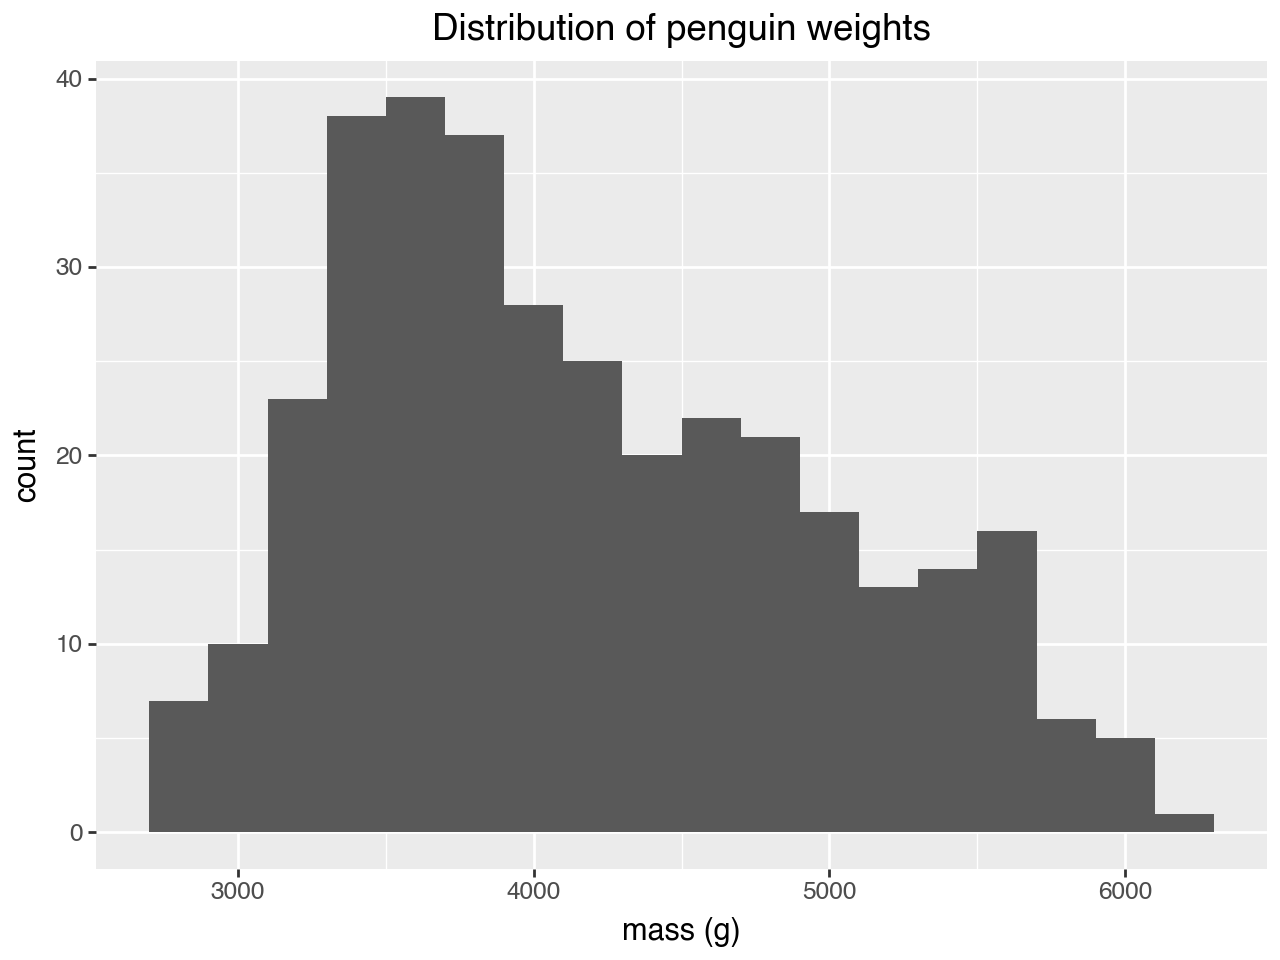

In [2]:
(
    p9.ggplot(penguins, p9.aes(x='body_mass_g'))
    + p9.geom_histogram(binwidth=200)
    + p9.labs(title='Distribution of penguin weights', x='mass (g)')
)

We can use color to separate the genders, where we can see the male penguins are generally heavier, and there are fewer of them. Note that in this presentation, it is unclear if the data is stacked or overlayed 

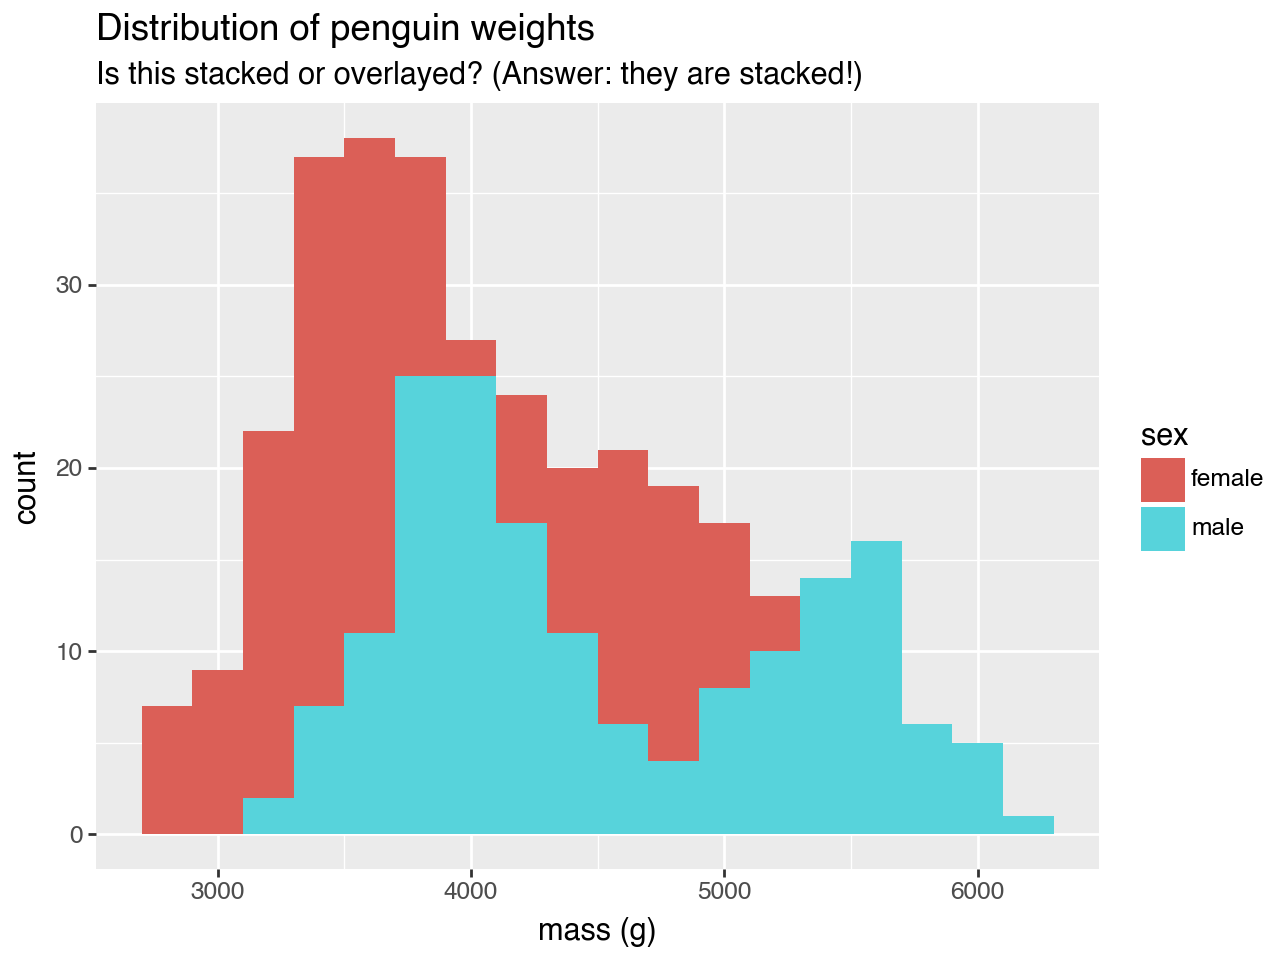

In [3]:
(
    p9.ggplot(penguins.dropna(), p9.aes(x='body_mass_g', fill='sex'))
    + p9.geom_histogram(binwidth=200)
    + p9.labs(title='Distribution of penguin weights', subtitle="Is this stacked or overlayed? (Answer: they are stacked!)", x='mass (g)')
)

Let's use transparency to help with the overlay question

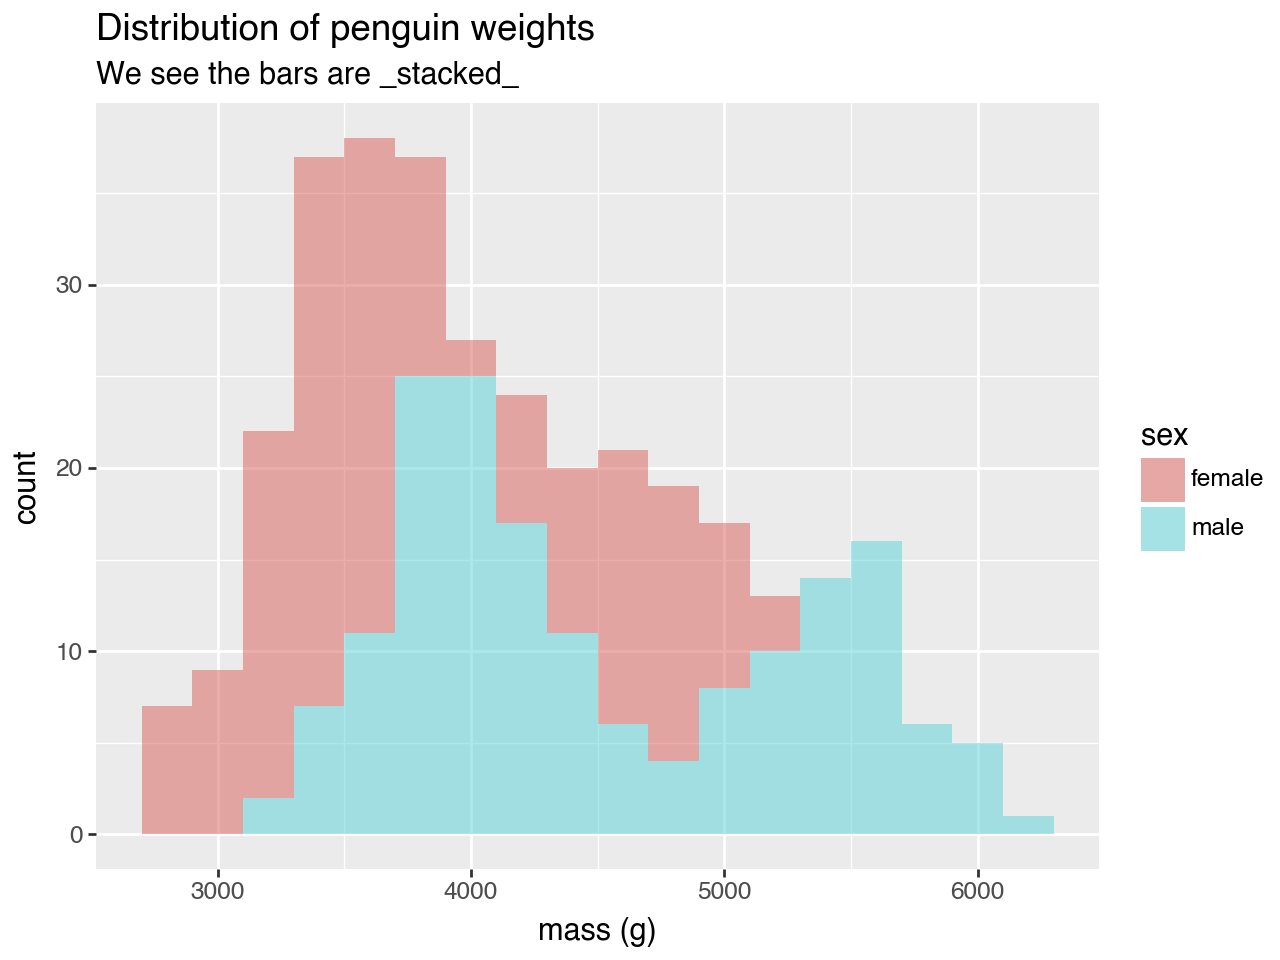

In [4]:
(
    p9.ggplot(penguins.dropna(), p9.aes(x='body_mass_g', fill='sex'))
    + p9.geom_histogram(binwidth=200, alpha=0.5)
    + p9.labs(title='Distribution of penguin weights', subtitle="We see the bars are _stacked_", x='mass (g)')
)

## Eliminate stacking: solution 1 -- faceting

We can use a facet plot to eliminate the stacking

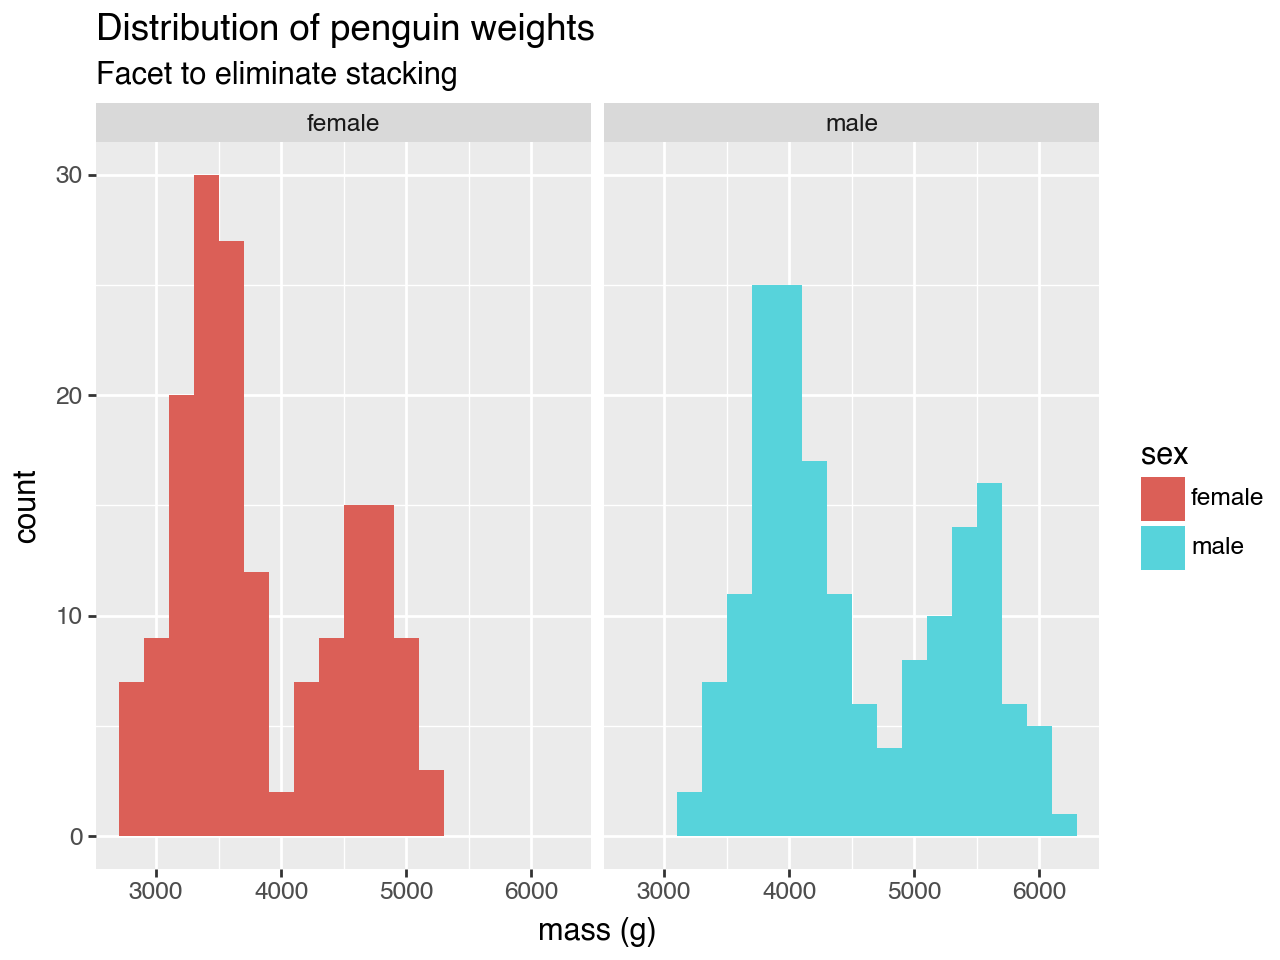

In [5]:
(
    p9.ggplot(penguins.dropna(), p9.aes(x='body_mass_g', fill='sex'))
    + p9.geom_histogram(binwidth=200)
    + p9.labs(title='Distribution of penguin weights', subtitle="Facet to eliminate stacking", x='mass (g)')
    + p9.facet_wrap('sex')
)

This has the downside that direct comparisons are more difficult e.g. there is a dip in weights, presumably from different species or islands. This dip is at 4 kg for female penguins, and around 4.75 kg for male penguins. It isn't immediately obvious that these dips are in different places.

## Eliminate stacking: solution 2 -- overlay

We can use the `position="identity"` argument to `geom_histogram` to overlay the graph. By default, the argument to `position` is `"stack"`.

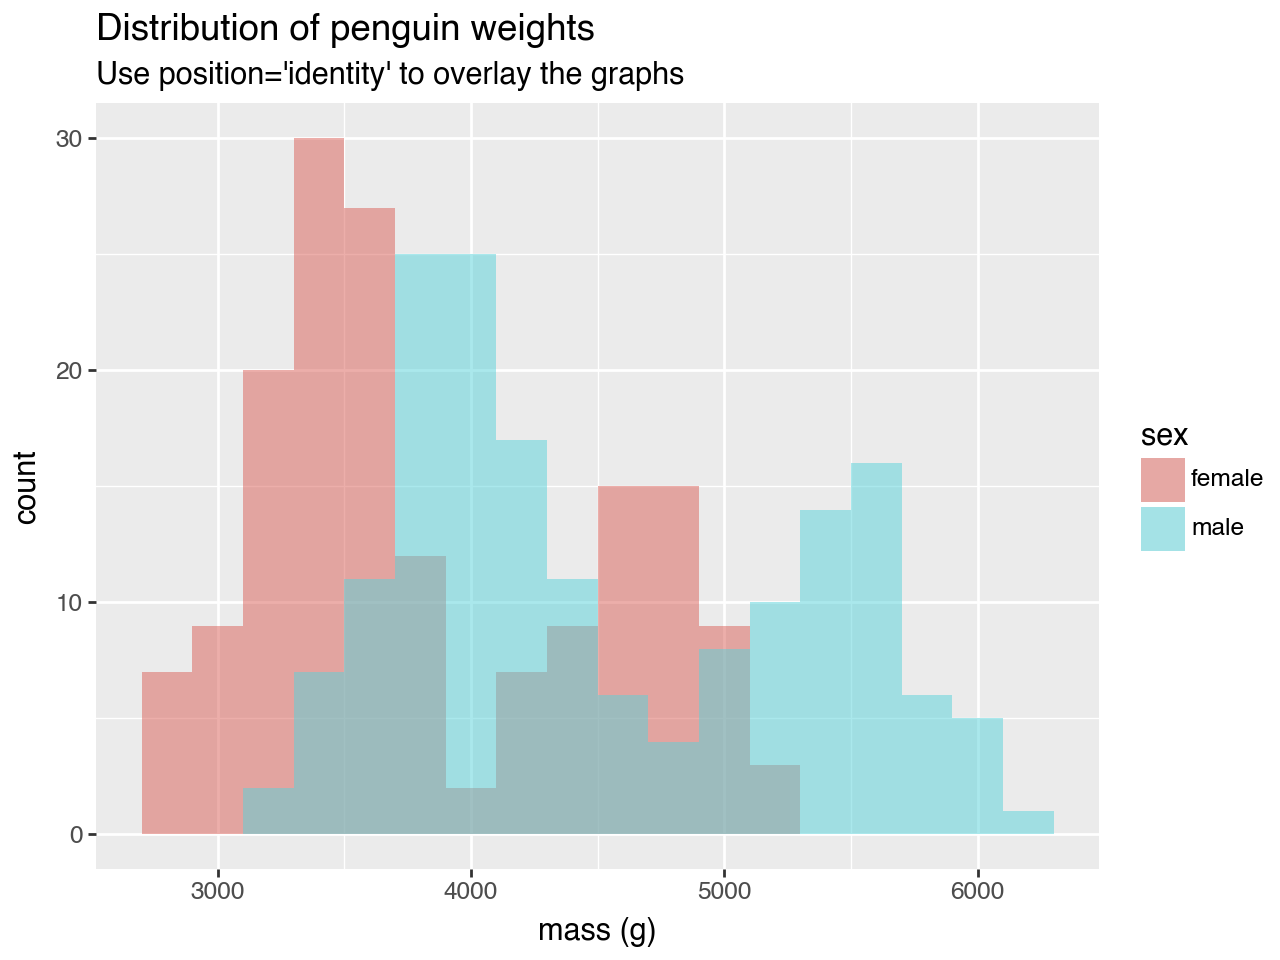

In [6]:
(
    p9.ggplot(penguins.dropna(), p9.aes(x='body_mass_g', fill='sex'))
    + p9.geom_histogram(binwidth=200, alpha=0.5, position="identity")
    + p9.labs(title='Distribution of penguin weights', subtitle="Use position='identity' to overlay the graphs", x='mass (g)')
)

## Making relative histograms

If we just want to compare the distributions, we can pass in `y='stat(density)'` instead. The default for a histogram is `'stat(count)'`. In R's `ggplot`, this would be written as `..density..` instead.

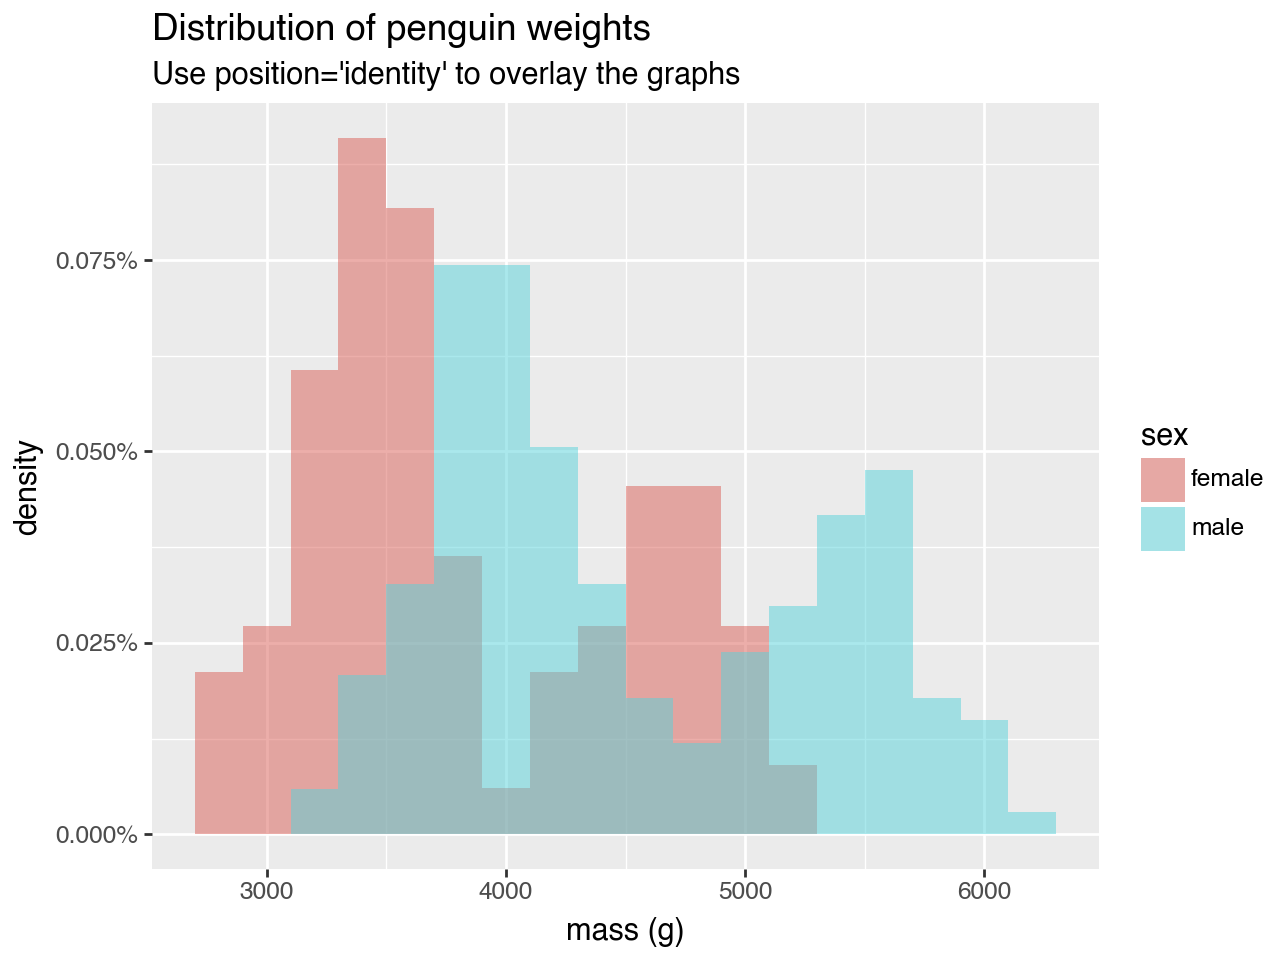

In [7]:
(
    p9.ggplot(penguins.dropna(), p9.aes(x='body_mass_g', y='stat(density)', fill='sex'))
    + p9.geom_histogram(binwidth=200, alpha=0.5, position="identity")
    + p9.labs(title='Distribution of penguin weights', subtitle="Use position='identity' to overlay the graphs", x='mass (g)')
    + p9.scale_y_continuous(labels=lambda v: [f"{vv:.3%}" for vv in v])
)

This doesn't make much of a difference, as the total gender numbers were pretty even:

In [8]:
penguins.dropna().sex.value_counts()

sex
male      168
female    165
Name: count, dtype: int64

We can see a more dramatic result if we partition by species instead:

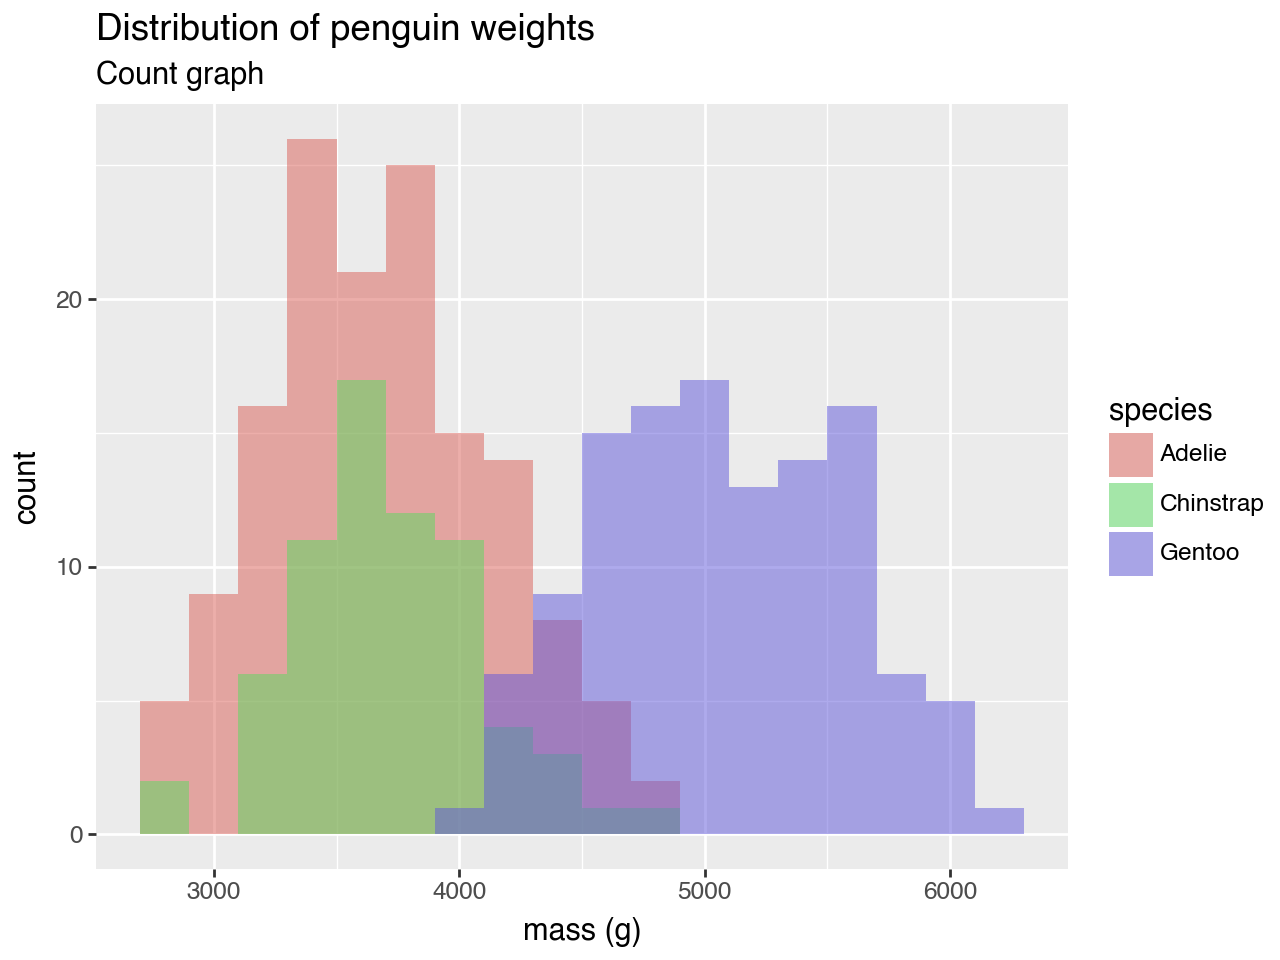

In [9]:
(
    p9.ggplot(penguins.dropna(), p9.aes(x='body_mass_g', fill='species'))
    + p9.geom_histogram(binwidth=200, alpha=0.5, position="identity")
    + p9.labs(title='Distribution of penguin weights', subtitle="Count graph", x='mass (g)')
)

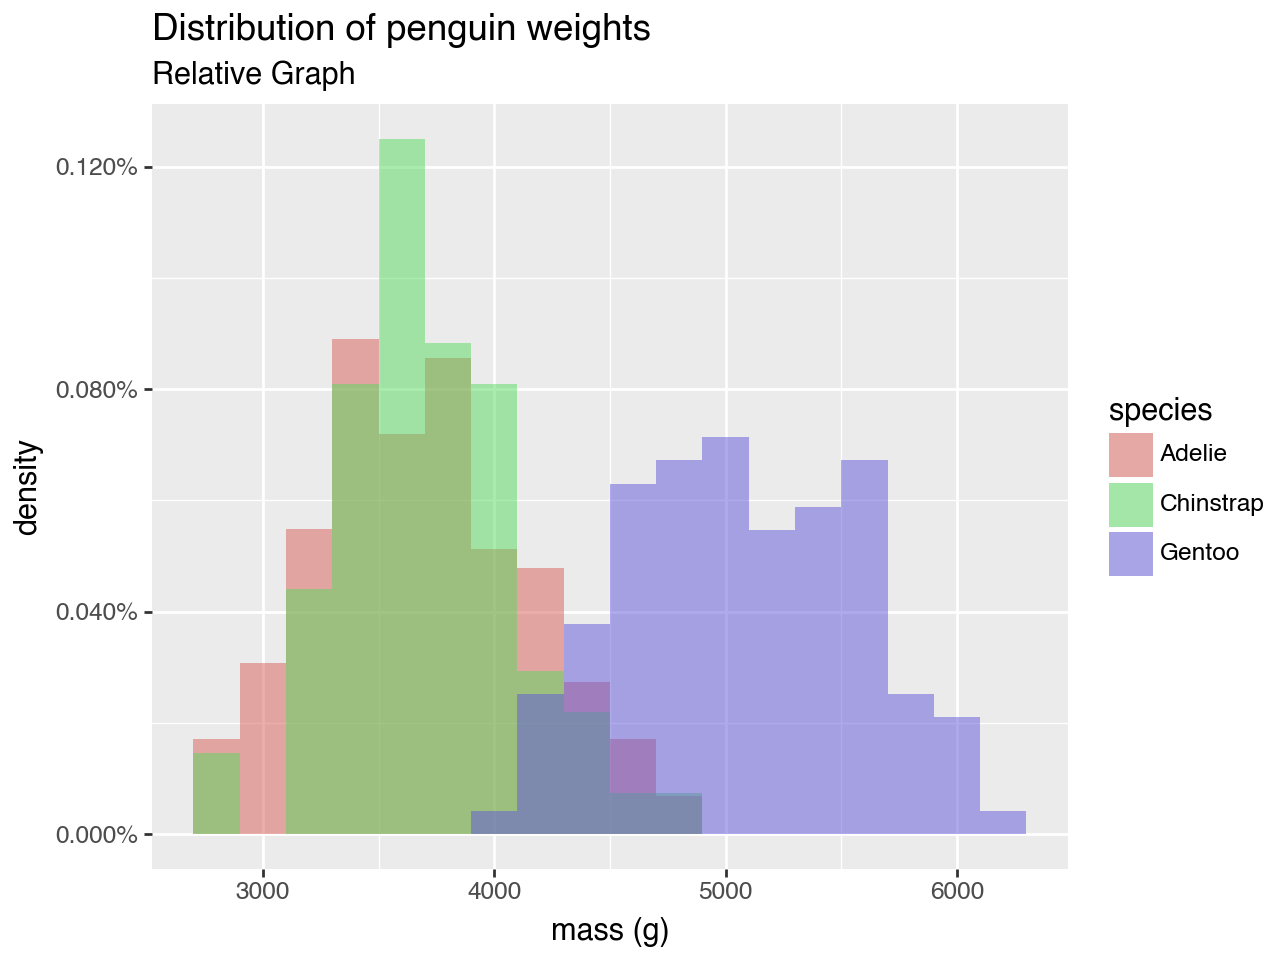

In [10]:
(
    p9.ggplot(penguins.dropna(), p9.aes(x='body_mass_g', y='stat(density)', fill='species'))
    + p9.geom_histogram(binwidth=200, alpha=0.5, position="identity")
    + p9.labs(title='Distribution of penguin weights', subtitle="Relative Graph", x='mass (g)')
    + p9.scale_y_continuous(labels=lambda v: [f"{vv:.3%}" for vv in v])
)

If you were intereseted in the question, "at a given mass, what % of penguins are which species?" you could use `position="fill"` instead. This scales each bin from 0 to 100%, and tells us how much of the data is in each bin.

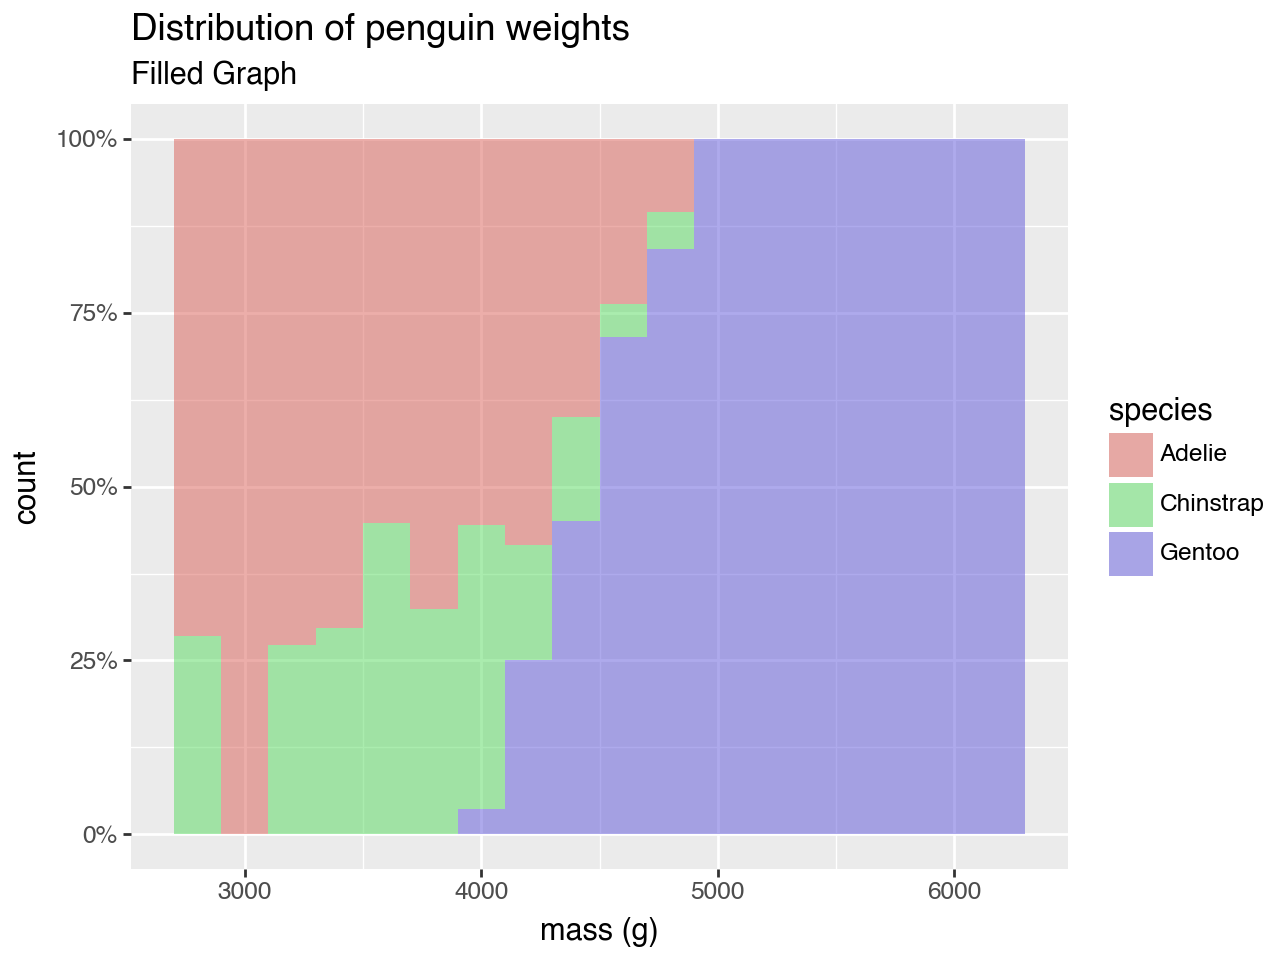

In [11]:
(
    p9.ggplot(penguins.dropna(), p9.aes(x='body_mass_g', y='stat(count)', fill='species'))
    + p9.geom_histogram(binwidth=200, alpha=0.5, position="fill")
    + p9.labs(title='Distribution of penguin weights', subtitle="Filled Graph", x='mass (g)')
    + p9.scale_y_continuous(labels=lambda v: [f"{vv:.0%}" for vv in v])
)

## Putting counts above the bars

This is tricker than regular labels, because we are trying to access the result of a computation (if we already have the counts, we could use `geom_label` to add them automatically). Below is a way of adding when using the identity position using `stat_bin`. Example inspired from [stack overflow](https://stackoverflow.com/questions/24198896/get-values-and-positions-to-label-a-ggplot-histogram#:~:text=ggplot%20%28csub%2Caes%20%28x%20%3D%20Anomaly10y%29%29%20%2B%20geom_histogram%20%28%29,original%20data%2C%20but%20generated%20by%20the%20geom_histogram%20function).

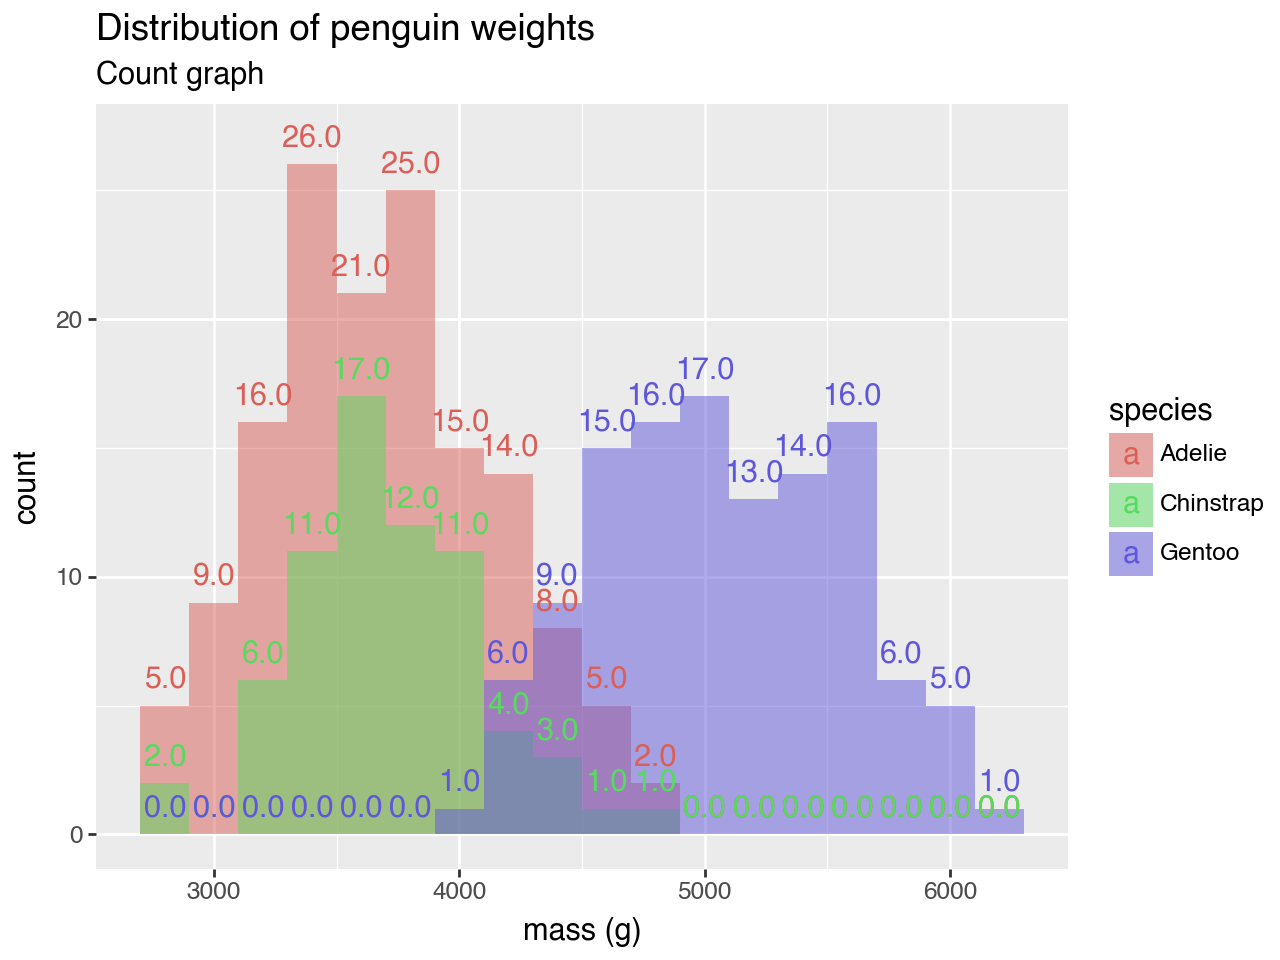

In [12]:
(
    p9.ggplot(penguins.dropna(), p9.aes(x='body_mass_g', fill="species"))
    + p9.geom_histogram(binwidth=200, alpha=0.5, position="identity")
    + p9.labs(title='Distribution of penguin weights', subtitle="Count graph", x='mass (g)')
    + p9.stat_bin(binwidth=200, geom="text", mapping=p9.aes(label="..count..", color='species'), position=p9.position_identity(), nudge_y=1)
)

If we have the slightly simpler use-case of only one species, the `position_stack` provides a slightly nicer interface. Note that `vjust` is as a fraction of the bar height (so 1 places right on top of the bar). This defaults at 0.5 (inside the bar). You can still use `nudge_y` if you want the values to be a constant offset upwards.

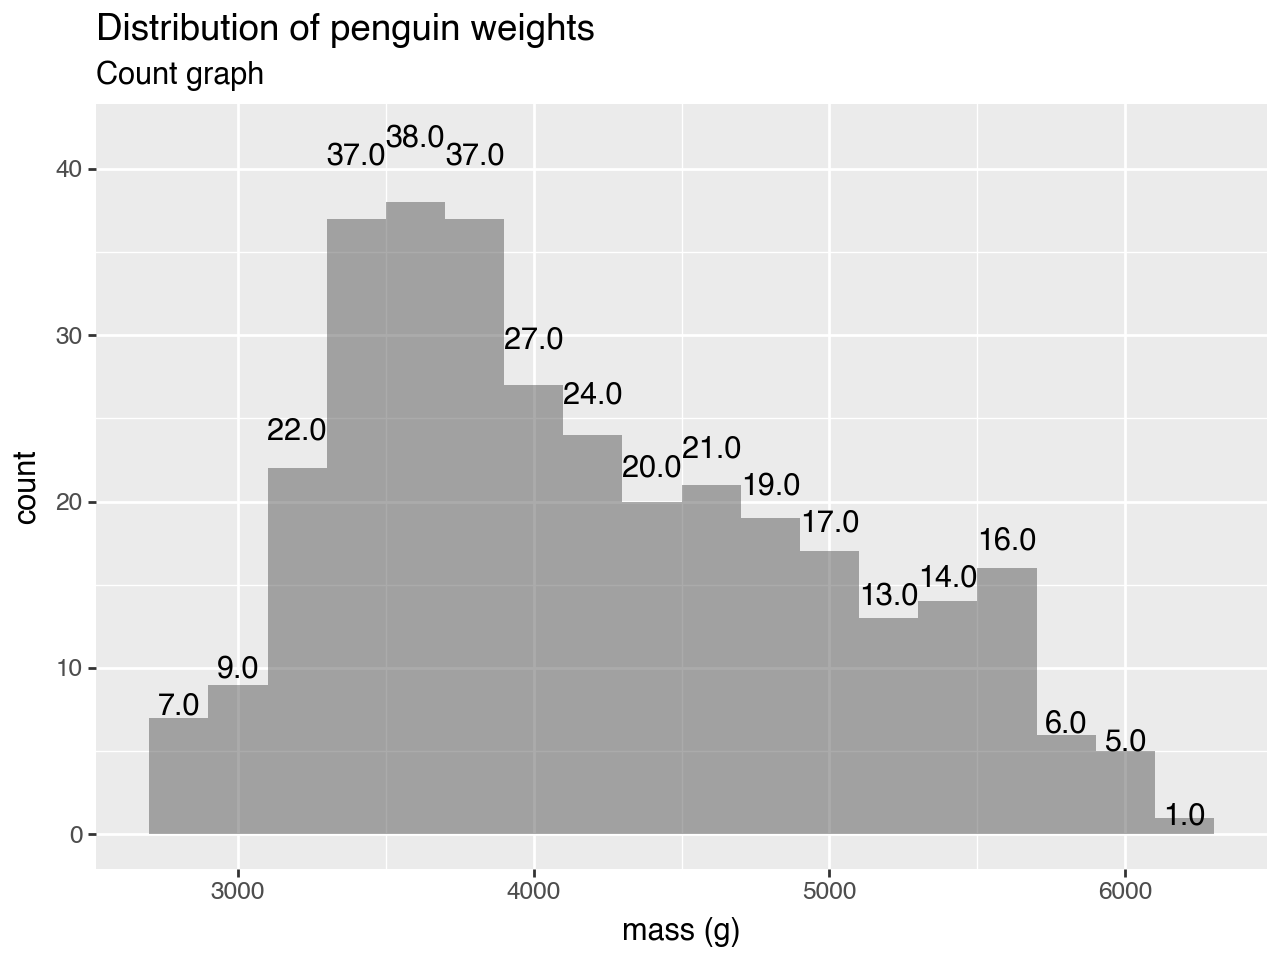

In [13]:
(
    p9.ggplot(penguins.dropna(), p9.aes(x='body_mass_g'))
    + p9.geom_histogram(binwidth=200, alpha=0.5)
    + p9.labs(title='Distribution of penguin weights', subtitle="Count graph", x='mass (g)')
    + p9.stat_bin(binwidth=200, geom="text", mapping=p9.aes(label="..count.."), position=p9.position_stack(vjust=1.1))
)

## Building histograms with pre-collected data

We can imagine that we pull data already binned from some external source (e.g. a database), and we want to plot that, as we only need the summary statistics

In [14]:
prebinned = ( 
    penguins
    .assign(mass_bin=lambda x: x.body_mass_g//100)
    .assign(individuals=1)
    .groupby('mass_bin')
    ['individuals']
    .count()
    .reset_index()
)
# our simulation of what we pull
prebinned.head()

,mass_bin,individuals
0,27.0,1
1,28.0,2
2,29.0,6
3,30.0,7
4,31.0,7


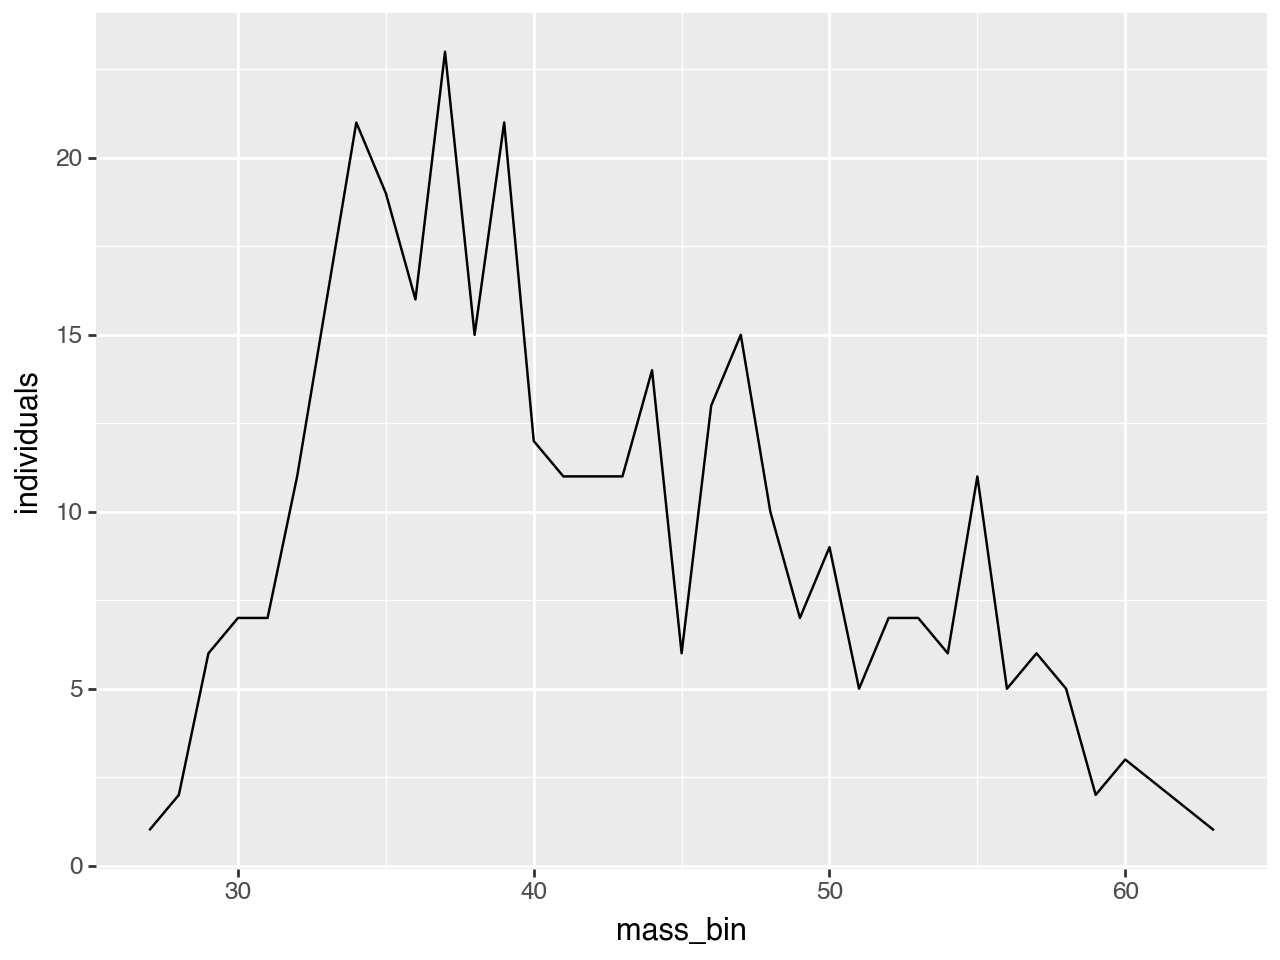

In [15]:
(
    p9.ggplot(prebinned, p9.aes(x='mass_bin'))
    + p9.geom_line(mapping=p9.aes(y='individuals'))
)

We can turn this into a bar chart / histogram in the following way:

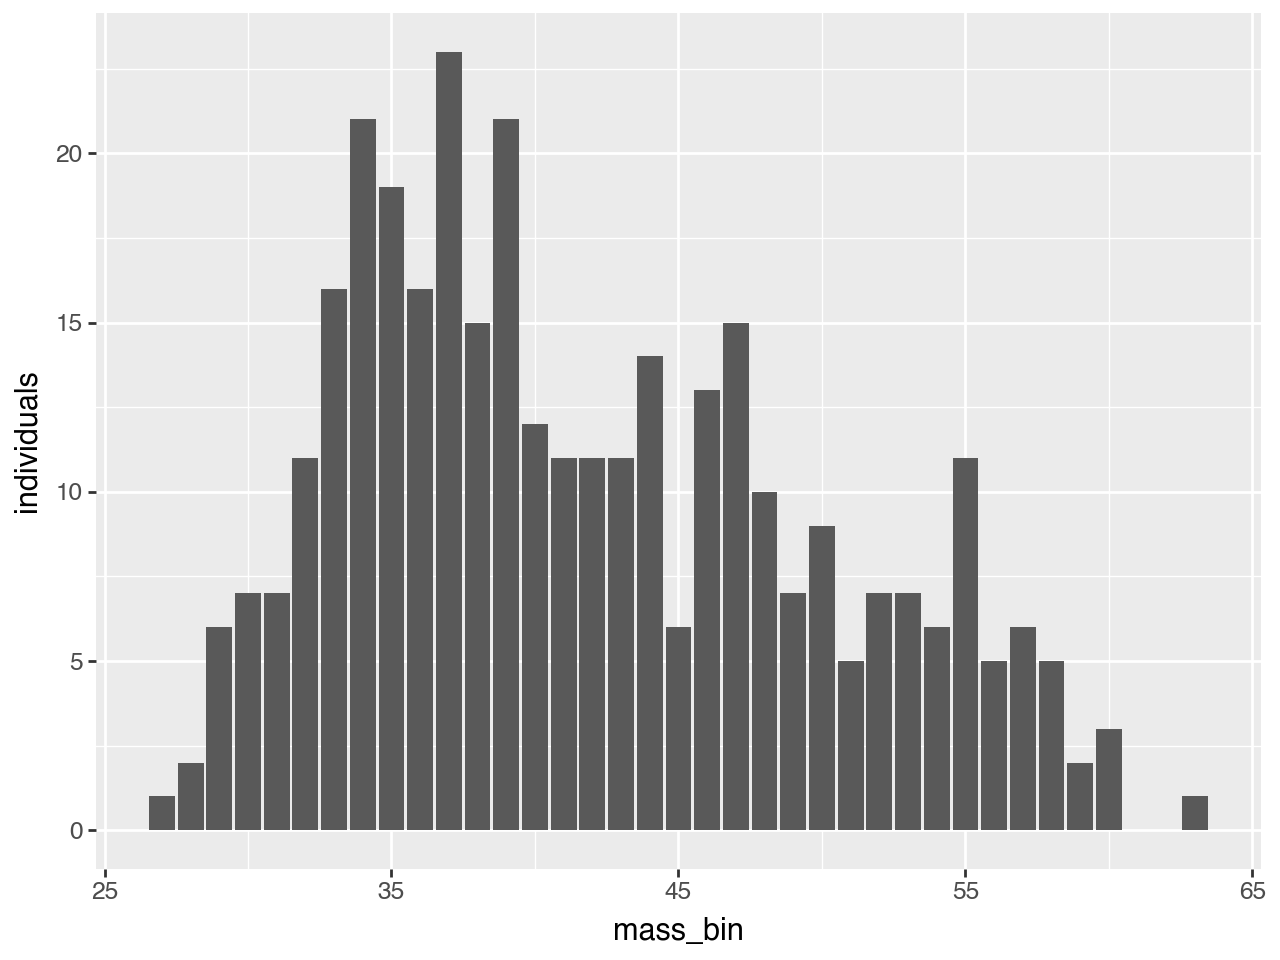

In [16]:
(
    p9.ggplot(prebinned, p9.aes(x='mass_bin', y='individuals'))
    + p9.geom_bar(stat="identity")
)